In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torchview
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=20fb1affe9b34e6fdfdd1a5e05dc1dad5014d387d21ab09d7df8f91b603cc87f
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
libc = ctypes.CDLL("libc.so.6")
seed = 42
torch.manual_seed(seed)

In [4]:
# Open the HDF5 file
import h5py
with h5py.File('/kaggle/input/autoencoders-labelled/Dataset_Specific_labelled.h5', 'r') as file:
    # List all the groups in the file
    print("Groups in the HDF5 file:")
    for group in file:
        print(group)

    # Get information about a specific dataset
    dataset = file['jet']
    print("Dataset shape:", dataset.shape)
    print("Dataset dtype:", dataset.dtype)
    
    dataset = file['Y']
    print("Dataset shape:", dataset.shape)
    print("Dataset dtype:", dataset.dtype)


    # Explore attributes of the dataset
    print("Dataset attributes:")
    for attr_name, attr_value in dataset.attrs.items():
        print(f"{attr_name}: {attr_value}")

    X = np.array(file['jet'][:])
    Y = np.array(file['Y'][:])
    # Explore more datasets, groups, and attributes as needed


Groups in the HDF5 file:
Y
jet
Dataset shape: (10000, 125, 125, 8)
Dataset dtype: float32
Dataset shape: (10000, 1)
Dataset dtype: float32
Dataset attributes:


In [5]:
X.shape

(10000, 125, 125, 8)

In [6]:
import numpy as np

import torch

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


In [7]:
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

class Encoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.mask_ratio = 0.75
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x):
        
        imgs = self.patchify(x)
        
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        
        
        
        return x, mask, ids_restore, imgs
    
class Decoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def forward(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x
    
class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder, mask_ratio):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.mask_ratio = mask_ratio
        
    def forward(self, x):
        x, mask, ids_restore, imgs = self.encoder(x)
        pred = self.decoder(x, ids_restore)
        
        return imgs, pred, mask
    
def mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75, **kwargs):
    encoder = Encoder(
        img_size=img_size, patch_size=5, embed_dim=768, depth=8, num_heads=12,
        decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    decoder = Decoder(
        img_size=img_size, patch_size=5, embed_dim=768, depth=8, num_heads=12,
        decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    model = Masked_VIT(encoder, decoder, mask_ratio)
    
    return model

# Instantiate the model
model = mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75)
# model = torch.load('/kaggle/input/pretrained-weights-autoencoder/model.pth')

In [8]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 648.7 kB/s eta 0:00:00


In [9]:
# model.module.encoder

In [10]:
from einops import repeat, rearrange
from einops.layers.torch import Rearrange
class VIT_classifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.patch_embed = encoder.patch_embed
        self.cls_token = encoder.cls_token
        self.pos_embed = encoder.pos_embed  # Corrected attribute name
        self.patchify = encoder.patchify
        self.transformer = encoder.blocks  # Corrected attribute name
        self.layer_norm = encoder.norm  # Corrected attribute name
        self.head = torch.nn.Linear(self.pos_embed.shape[-1], num_classes)
        self.blocks = encoder.blocks
        
        self.avg_pool = nn.AdaptiveAvgPool1d((1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=625, out_features=64)
        self.fc_1 = nn.Linear(in_features=64, out_features=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        x = self.patch_embed(x)
        
        x = x + self.pos_embed[:, 1:, :]

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        
        x = self.layer_norm(x)
        
        x = x[:,1:,:]
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.fc_1(x)
        x = self.sigmoid(x)
        
        return x

encoder = model.encoder
classifier = VIT_classifier(encoder, 2)

In [11]:
# import torchvision
# from torchview import draw_graph
# from torchviz import make_dot

# # # encoder = Encoder(
# # #         img_size=125, patch_size=5, embed_dim=768, depth=8, num_heads=12,
# # #         decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
# # #         mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6)
# # # encoder = model.encoder

# model_graph = draw_graph(classifier, input_size=(1,8,125,125), expand_nested=True)
# model_graph.visual_graph

In [12]:
import torchvision

In [13]:
for _z in range(8):
    X[:,:,:,_z] = (X[:,:,:,_z] - X[:,:,:,_z].mean()) / (X[:,:,:,_z].std())

In [14]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, y, transform):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = self.x[idx]
        label = self.y[idx]
        
        if self.transform:
            img_1 = self.transform(img_1)
            
        sample = {'img' : img_1, 'label' : label}
        
        return sample
    
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = Custom_Dataset(X, Y, transform = transform)
sample = dataset.__getitem__(0)
print((sample['img']).shape)
print(sample['label'].shape)

torch.Size([8, 125, 125])
(1,)


In [15]:
DEVICE = torch.device('cuda')

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import h5py
from torch import Tensor
from typing import Type
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torchview import draw_graph
from torchviz import make_dot
import warnings
warnings.filterwarnings("ignore")
from torchmetrics import Accuracy
import copy
import torch.optim as optim
import tqdm
from tqdm import tqdm
from torchmetrics import Accuracy
from torch.utils.data import TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from PIL import Image


def model_train(fold, model, epochs, train_dataloader, test_dataloader):
    
    # --------------------Loss function and optimizer--------------------
    criterion = nn.BCELoss()  # Binary Cross Entropy
    optimizer = optim.AdamW(model.parameters(), lr=1.5e-5)
    # -------------------------------------------------------------------

    best_acc = -np.inf  # Init to negative infinity
    best_weights = None
    accuracy = Accuracy(task = 'binary').to(DEVICE)
 
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        train_pred = []
        val_pred = []
        
        # --------------------Training Loop--------------------
        model.train()
        for batch in tqdm(train_dataloader):
            images, labels = batch['img'], batch['label']
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_pred.append(loss.item())

            # Calculate training accuracy
            train_acc = accuracy(outputs, labels)
            train_accuracies.append(train_acc.item())

        train_loss = np.mean(train_pred)
        # -------------------------------------------------------
        # -------------------------------------------------------
        
        # --------------------Validation Loop--------------------
        model.eval()
        with torch.no_grad():
            for val_batch in tqdm(test_dataloader):
                val_images, val_labels = val_batch['img'], val_batch['label']
                val_images = val_images.to(DEVICE)
                val_labels = val_labels.to(DEVICE)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_pred.append(val_loss.item())

                # Calculate validation accuracy
                val_acc = accuracy(val_outputs, val_labels)
                val_accuracies.append(val_acc.item())

        val_loss = np.mean(val_pred)
        # -------------------------------------------------------
        # -------------------------------------------------------
        
        # Print and store losses and accuracies
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {np.mean(train_accuracies):.4f}, Valid Loss: {val_loss:.4f}, Valid Accuracy: {np.mean(val_accuracies):.4f}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save best model
        if max(train_accuracies) > best_acc:
            best_acc = max(train_accuracies)
            best_weights = copy.deepcopy(model.state_dict())
    
    # Save the best model
    torch.save(best_weights, f'./best_model_{fold}.pth')

    # Plot training and validation losses
    return train_losses, val_losses, train_accuracies, val_accuracies


In [17]:
del classifier
gc.collect()
torch.cuda.empty_cache()

In [18]:
# model = mae_vit_base_patch16_dec512d8b(img_size=125)

In [19]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
training_loss = []
validation_loss = []
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
classifier = VIT_classifier(model.encoder, 2)
NUM_GPU = torch.cuda.device_count()
if NUM_GPU > 1:
    classifier = nn.DataParallel(classifier)
classifier = classifier.to(DEVICE)

train_losses, val_losses, train_accuracies, val_accuracies = model_train(1,classifier, 15, train_dataloader, val_dataloader)

100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 1/15, Train Loss: 0.6930, Train Accuracy: 0.5084, Valid Loss: 0.6919, Valid Accuracy: 0.5312


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 2/15, Train Loss: 0.6930, Train Accuracy: 0.5084, Valid Loss: 0.6919, Valid Accuracy: 0.5312


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Epoch 3/15, Train Loss: 0.6915, Train Accuracy: 0.5091, Valid Loss: 0.6856, Valid Accuracy: 0.5677


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 4/15, Train Loss: 0.6824, Train Accuracy: 0.5384, Valid Loss: 0.6722, Valid Accuracy: 0.5887


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 5/15, Train Loss: 0.6652, Train Accuracy: 0.5600, Valid Loss: 0.6498, Valid Accuracy: 0.6047


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 6/15, Train Loss: 0.6335, Train Accuracy: 0.5812, Valid Loss: 0.6285, Valid Accuracy: 0.6176


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 7/15, Train Loss: 0.6173, Train Accuracy: 0.5973, Valid Loss: 0.6082, Valid Accuracy: 0.6295


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 8/15, Train Loss: 0.6127, Train Accuracy: 0.6088, Valid Loss: 0.5938, Valid Accuracy: 0.6400


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 9/15, Train Loss: 0.5774, Train Accuracy: 0.6220, Valid Loss: 0.5486, Valid Accuracy: 0.6522


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Epoch 10/15, Train Loss: 0.5352, Train Accuracy: 0.6362, Valid Loss: 0.5218, Valid Accuracy: 0.6635


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Epoch 11/15, Train Loss: 0.5161, Train Accuracy: 0.6479, Valid Loss: 0.5728, Valid Accuracy: 0.6695


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 12/15, Train Loss: 0.5093, Train Accuracy: 0.6580, Valid Loss: 0.4864, Valid Accuracy: 0.6794


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 13/15, Train Loss: 0.4954, Train Accuracy: 0.6672, Valid Loss: 0.4882, Valid Accuracy: 0.6867


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 14/15, Train Loss: 0.4767, Train Accuracy: 0.6758, Valid Loss: 0.5227, Valid Accuracy: 0.6919


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Epoch 15/15, Train Loss: 0.5238, Train Accuracy: 0.6813, Valid Loss: 0.5265, Valid Accuracy: 0.6951


In [20]:
# torch.save(model, f'./best_model.pth')

In [21]:
encoder = classifier.module.encoder

In [22]:
torch.save(encoder, 'encoder.pth')

In [23]:
torch.save(classifier.module, 'model.pth')

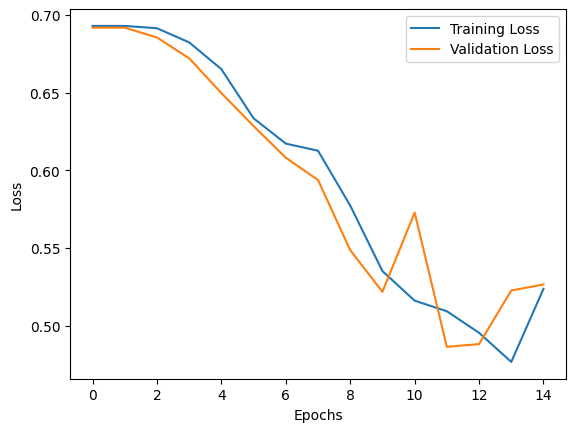

In [24]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# class MaskedAutoencoderViT(nn.Module):
#     """ Masked Autoencoder with VisionTransformer backbone
#     """
#     def __init__(self, img_size=224, patch_size=16, in_chans=8,
#                  embed_dim=1024, depth=24, num_heads=16,
#                  decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
#                  mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
#         super().__init__()

#         # --------------------------------------------------------------------------
#         # MAE encoder specifics
#         self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
#         num_patches = self.patch_embed.num_patches

#         self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
#         self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

#         self.blocks = nn.ModuleList([
#             Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
#             for i in range(depth)])
#         self.norm = norm_layer(embed_dim)
#         # --------------------------------------------------------------------------

#         # --------------------------------------------------------------------------
#         # MAE decoder specifics
#         self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

#         self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

#         self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

#         self.decoder_blocks = nn.ModuleList([
#             Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
#             for i in range(decoder_depth)])

#         self.decoder_norm = norm_layer(decoder_embed_dim)
#         self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
#         # --------------------------------------------------------------------------

#         self.norm_pix_loss = norm_pix_loss

#         self.initialize_weights()

#     def initialize_weights(self):
#         # initialization
#         # initialize (and freeze) pos_embed by sin-cos embedding
#         pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
#         self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

#         decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
#         self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

#         # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
#         w = self.patch_embed.proj.weight.data
#         torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

#         # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
#         torch.nn.init.normal_(self.cls_token, std=.02)
#         torch.nn.init.normal_(self.mask_token, std=.02)

#         # initialize nn.Linear and nn.LayerNorm
#         self.apply(self._init_weights)

#     def _init_weights(self, m):
#         if isinstance(m, nn.Linear):
#             # we use xavier_uniform following official JAX ViT:
#             torch.nn.init.xavier_uniform_(m.weight)
#             if isinstance(m, nn.Linear) and m.bias is not None:
#                 nn.init.constant_(m.bias, 0)
#         elif isinstance(m, nn.LayerNorm):
#             nn.init.constant_(m.bias, 0)
#             nn.init.constant_(m.weight, 1.0)

#     def patchify(self, imgs):
#         """
#         imgs: (N, 8, H, W)
#         x: (N, L, patch_size**2 *3)
#         """
#         p = self.patch_embed.patch_size[0]
#         assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

#         h = w = imgs.shape[2] // p
#         x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
#         x = torch.einsum('nchpwq->nhwpqc', x)
#         x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
#         return x

#     def unpatchify(self, x):
#         """
#         x: (N, L, patch_size**2 *3)
#         imgs: (N, 8, H, W)
#         """
#         p = self.patch_embed.patch_size[0]
#         h = w = int(x.shape[1]**.5)
#         assert h * w == x.shape[1]
        
#         x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
#         x = torch.einsum('nhwpqc->nchpwq', x)
#         imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
#         return imgs

#     def random_masking(self, x, mask_ratio):
#         """
#         Perform per-sample random masking by per-sample shuffling.
#         Per-sample shuffling is done by argsort random noise.
#         x: [N, L, D], sequence
#         """
#         N, L, D = x.shape  # batch, length, dim
#         len_keep = int(L * (1 - mask_ratio))
        
#         noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
#         # sort noise for each sample
#         ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
#         ids_restore = torch.argsort(ids_shuffle, dim=1)

#         # keep the first subset
#         ids_keep = ids_shuffle[:, :len_keep]
#         x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

#         # generate the binary mask: 0 is keep, 1 is remove
#         mask = torch.ones([N, L], device=x.device)
#         mask[:, :len_keep] = 0
#         # unshuffle to get the binary mask
#         mask = torch.gather(mask, dim=1, index=ids_restore)

#         return x_masked, mask, ids_restore

#     def forward_encoder(self, x, mask_ratio):
#         # embed patches
#         x = self.patch_embed(x)

#         # add pos embed w/o cls token
#         x = x + self.pos_embed[:, 1:, :]

#         # masking: length -> length * mask_ratio
#         x, mask, ids_restore = self.random_masking(x, mask_ratio)

#         # append cls token
#         cls_token = self.cls_token + self.pos_embed[:, :1, :]
#         cls_tokens = cls_token.expand(x.shape[0], -1, -1)
#         x = torch.cat((cls_tokens, x), dim=1)

#         # apply Transformer blocks
#         for blk in self.blocks:
#             x = blk(x)
#         x = self.norm(x)

#         return x, mask, ids_restore

#     def forward_decoder(self, x, ids_restore):
#         # embed tokens
#         x = self.decoder_embed(x)

#         # append mask tokens to sequence
#         mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
#         x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
#         x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
#         x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

#         # add pos embed
#         x = x + self.decoder_pos_embed

#         # apply Transformer blocks
#         for blk in self.decoder_blocks:
#             x = blk(x)
#         x = self.decoder_norm(x)

#         # predictor projection
#         x = self.decoder_pred(x)

#         # remove cls token
#         x = x[:, 1:, :]

#         return x

#     def forward(self, imgs, mask_ratio=0.75):
#         latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
#         pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
# #         loss = self.forward_loss(imgs, pred, mask)
#         imgs = self.patchify(imgs)
#         return imgs, pred, mask


# # def mae_vit_base_patch16_dec512d8b(**kwargs):
# #     model = MaskedAutoencoderViT(
# #         img_size=125,patch_size=5, embed_dim=768, depth=12, num_heads=12,
# #         decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
# #         mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
# #     return model


# # # set recommended archs
# # model = mae_vit_base_patch16_dec512d8b (img_size = 125) # decoder: 512 dim, 8 blocks
# def mae_vit_base_patch16_dec512d8b(img_size=125, **kwargs):
#     model = MaskedAutoencoderViT(
#         img_size=img_size, patch_size=5, embed_dim=768, depth=8, num_heads=12,
#         decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
#         mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     return model

# # Instantiate the model
# model = mae_vit_base_patch16_dec512d8b(img_size=125)
